### Imports

In [1]:
import glob
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from PIL import Image
import imageio
from sklearn.utils import shuffle
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm

print(tf.__version__)

1.8.0


### Helper Functions

In [2]:
def display_image(ax, image, label, classes):
    ''' Display selected image.
    
    Paramters:
        ax (matplotlib.figure.Figure): figure to display images.
        image numpy.ndarray: 512 x 512 x 3.
        labels (list(numpy.int32)): 300 x 1.
        classes (list(str)): 3 x 1.
    
    Returns:
        NA: figure
        
    '''
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.real(image))
    plt.xlabel(classes[label])

In [3]:
def display_images(ax, images, labels, classes, size):
    ''' Display selected images.
    
    Paramters:
        ax (matplotlib.figure.Figure): figure to display images.
        images (list(numpy.ndarray)): 300 x 512 x 512 x 3.
        labels (list(numpy.int32)): 300 x 1.
        classes (list(str)): 3 x 1.
        size (tuple): 1 x 2, dimensions of the subplot (height, width).
    
    Returns:
        NA: figure
        
    '''
    
    for i in range(0, size[0]*size[1]):
        plt.subplot(size[0], size[1], i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

### Load Data

In [4]:
current_dir = os.getcwd()
data_dir = current_dir + '\original_data'
classes = os.listdir(data_dir)

image_size = (512, 512, 3)
images = np.empty((0, image_size[0], image_size[1], 3), dtype=np.uint8)
labels = np.empty((0,), dtype=np.uint8)

for i in tqdm(range(0, len(classes))):
    print('Class ' + str(i+1) + ': ' + classes[i])
    
    class_dir = data_dir + '\\' + classes[i]
    print('Loading images from:', class_dir)
    imgs = glob.glob(class_dir + '/*.png')

    imgs = np.array([np.array(Image.open(img)) for img in imgs])
    imgs = imgs.astype(int)
    
    images = np.append(images, imgs, axis=0)
    labels = np.append(labels, (i * np.ones((imgs.shape[0],))).astype(int), axis=0)

print()
print('Images:', images.shape)
print('Labels:', labels.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

Class 1: Necrosis
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Necrosis


 33%|███▎      | 1/3 [00:02<00:04,  0.44it/s]

Class 2: Stroma
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Stroma


 67%|██████▋   | 2/3 [00:04<00:02,  0.43it/s]

Class 3: Tumor
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Tumor



Images: (300, 512, 512, 3)
Labels: (300,)


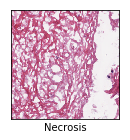

In [5]:
#display single image

ax = plt.figure(figsize=(2, 2))
display_image(ax, images[0], labels[0], classes)

### Randomize Image Order

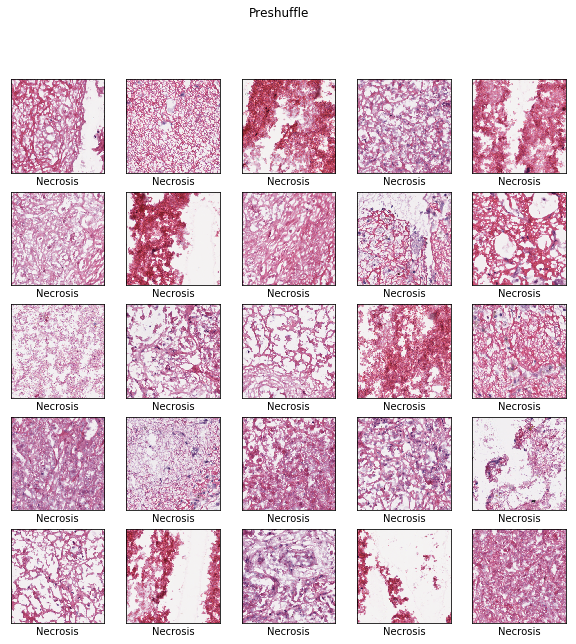

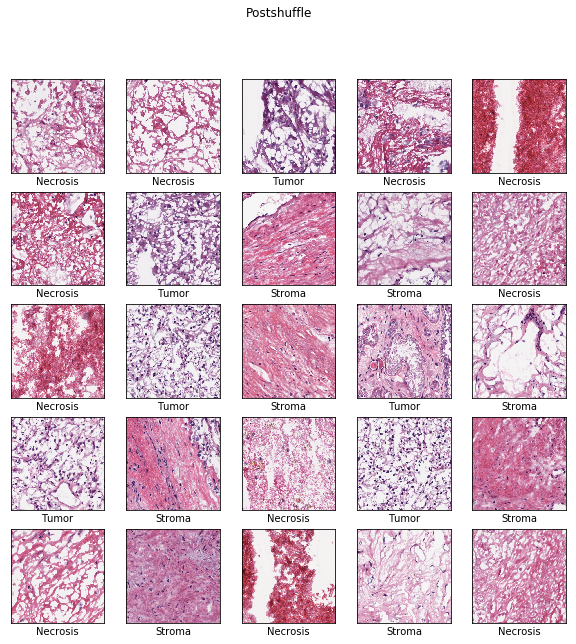

In [6]:
ax = plt.figure(figsize=(10, 10))
plt.suptitle('Preshuffle')
display_images(ax, images, labels, classes, (5, 5))

images, labels = shuffle(images, labels)

ax = plt.figure(figsize=(10, 10))
plt.suptitle('Postshuffle')
display_images(ax, images, labels, classes, (5, 5))

In [7]:
print(classes)

['Necrosis', 'Stroma', 'Tumor']


### Implement color normalization using Reinhard's Method

### Apply data augmentation: random crop (224x224), flip, rotation

In [8]:
crop_size = (224, 224)
num_augmentations_per_image = 5
num_orientations = 4

augmented_images = np.empty((0, crop_size[0], crop_size[1], 3), dtype=np.uint8)
augmented_labels = np.empty((0,), dtype=np.uint8)

for i in tqdm(range(0, 5)): #images.shape[0])):
    for _ in range(0, num_augmentations_per_image):
        flip = np.random.randint(0, 3)
        degrees = int(360 * np.random.randint(0, num_orientations) / num_orientations)

        print('Flip:', flip, 'Degrees:', degrees)
        
        flipped_image = np.zeros((image_size), dtype=np.uint8)
        temp = np.zeros((image_size), dtype=np.uint8)
        augmented_image = np.zeros((image_size), dtype=np.uint8)
        
        #flip
        if flip is 0: #don't modifiy
            flipped_image = images[i, :, :, :]
        elif flip is 1: #flip vertically
            flipped_image[::-1, :, :] = images[i, :, :, :]
        elif flip is 2: #flip horizontally
            flipped_image[:, ::-1, :] = images[i, :, :, :]
        else:
            print('invalid flip selection')
        
        #https://stackoverflow.com/questions/42519/how-do-you-rotate-a-two-dimensional-array
        #rotate CCW
        if degrees == 0:
            augmented_image = flipped_image
        elif degrees == 90:
            temp = np.transpose(flipped_image, axes=(1, 0, 2)) #transpose, don't modify axis 3
            augmented_image[::-1, :, :] = temp #flip rows
        elif degrees == 180:
            temp[::-1, :, :] = flipped_image #flip rows
            augmented_image[:, ::-1, :] = temp #flip columns
        elif degrees == 270: #-90
            temp = np.transpose(flipped_image, axes=(1, 0, 2)) #transpose, don't modify axis 3
            augmented_image[:, ::-1, :] = temp #flip columns
        else:
            print('invalid rotate selection')
        
        #crop
        (r, c) = (np.random.randint(0, image_size[0] - crop_size[0]), np.random.randint(0, image_size[1] - crop_size[1]))
        augmented_image = np.expand_dims(augmented_image[r:r+crop_size[0], c:c+crop_size[1]], axis=0) #1 x crop_size[0] x crop_size[1] x 3
        
        augmented_images = np.append(augmented_images, augmented_image, axis=0)
        augmented_labels = np.append(augmented_labels, np.expand_dims(labels[i], axis=0), axis=0)

print()
print('Augmented Images:', augmented_images.shape)
print('Augmented Labels:', augmented_labels.shape)

 80%|████████  | 4/5 [00:00<00:00, 25.71it/s]

Flip: 1 Degrees: 180
Flip: 0 Degrees: 90
Flip: 2 Degrees: 90
Flip: 1 Degrees: 270
Flip: 0 Degrees: 270
Flip: 0 Degrees: 270
Flip: 1 Degrees: 270
Flip: 0 Degrees: 270
Flip: 0 Degrees: 0
Flip: 2 Degrees: 270
Flip: 0 Degrees: 270
Flip: 1 Degrees: 270
Flip: 2 Degrees: 180
Flip: 0 Degrees: 180
Flip: 0 Degrees: 0
Flip: 2 Degrees: 0
Flip: 0 Degrees: 180
Flip: 1 Degrees: 0
Flip: 1 Degrees: 90
Flip: 0 Degrees: 90
Flip: 1 Degrees: 0
Flip: 2 Degrees: 90
Flip: 1 Degrees: 

180
Flip: 2 Degrees: 90
Flip: 2 Degrees: 270

Augmented Images: (25, 224, 224, 3)
Augmented Labels: (25,)


#### View Augmented Data

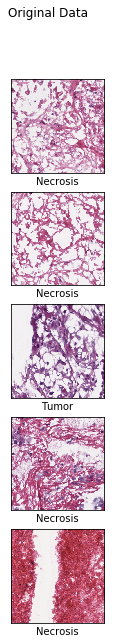

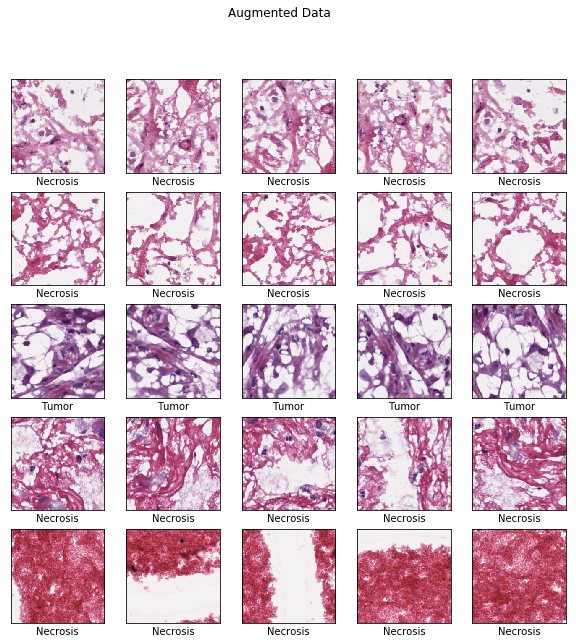

In [9]:
# ax = plt.figure(figsize=(10, 10))
# plt.suptitle('Original Data')
# display_images(ax, images, labels, classes, (5, 5))

ax = plt.figure(figsize=(10, 10))
plt.suptitle('Original Data')
display_images(ax, images, labels, classes, (5, 1))

ax = plt.figure(figsize=(10, 10))
plt.suptitle('Augmented Data')
display_images(ax, augmented_images, augmented_labels, classes, (5, 5))

#### Save Augmented Data

In [10]:
save_dir = current_dir + '\\augmented_data'
for current_class in range(0, len(classes)):
    new_dir = save_dir + '\\' + str(classes[current_class])
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

num_images_in_each_class = np.zeros((1, len(classes)), dtype=np.uint8)

for i in tqdm(range(0, len(augmented_images))):
    current_class = augmented_labels[i]
    num_images_in_each_class[0, current_class] += 1
    
    curr_dir = save_dir + '\\' + str(classes[current_class]) + '\\' + str(classes[current_class]) + '_' + '{:03d}'.format(num_images_in_each_class[0, current_class]) + '.png'
#     print(curr_dir)
    imageio.imwrite(curr_dir, augmented_images[i].astype(np.uint8))

print(num_images_in_each_class)

[[20  0  5]]
